<a href="https://colab.research.google.com/github/ErickQuinteroOsorio/edp_con_pinn/blob/main/notebooks/analisis_edp_con_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estructura y enterenamiento de la red neuronal fisicamente informada

In [10]:
# Listing 1: Initial settings for the heat equation
#----------------------------------------------------
import tensorflow as tf
# We set seeds initially. This feature controls the randomization of
# variables (e.g. initial weights of the network).
# By doing it so, we can reproduce same results.
tf.random.set_seed(123)

# 100 equidistant points in the domain are created
x = tf.linspace(0.0, 1.0, 100)

# boundary conditions T(0)=T(1)=0 and \kappa are introduced.
bcs_x = [0.0, 1.0]
bcs_T = [0.0, 0.0]

bcs_x_tensor = tf.convert_to_tensor(bcs_x)[:, None]
bcs_T_tensor = tf.convert_to_tensor(bcs_T)[:, None]
kappa = 0.5

# Number of iterations
N = 1000
# ADAM optimizer with learning rate of 0.005
optim = tf.keras.optimizers.Adam(learning_rate=0.005)
# Function for creating the model
def buildModel(num_hidden_layers, num_neurons_per_layer):
  tf.keras.backend.set_floatx("float32")

  # Initialize a feedforward neural network
  model = tf.keras.Sequential()
  # Input is one dimensional (one spatial dimension)
  # model.add(tf.keras.Input(1)) # así estaba en el libro y ya no funciona
  model.add(tf.keras.Input(shape=(1,))) # Corrected line

  # Append hidden layers
  for _ in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                    activation=tf.keras.activations.get("tanh"),
                                    kernel_initializer="glorot_normal",
                                    )
    )

  # Output is one-dimensional
  model.add(tf.keras.layers.Dense(1))
  return model


# determine the model size (3 hidden layers with 32 neurons each)
model = buildModel(3, 32)

# Listing 2: Loss function definition for the heat equation
#------------------------------------------------------------
# Boundary loss function
def boundary_loss(bcs_x_tensor, bcs_T_tensor):
  predicted_bcs = model(bcs_x_tensor)
  mse_bcs = tf.reduce_mean(tf.square(predicted_bcs - bcs_T_tensor))
  return mse_bcs

# the first derivative of the prediction
def get_first_deriv(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    T = model(x)
  T_x = tape.gradient(T, x)
  return T_x

# the second derivative of the prediction
def second_deriv(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    T_x = get_first_deriv(x)
  T_xx = tape.gradient(T_x, x)
  return T_xx

# Source term divided by \kappa
source_func = lambda x: (15 * x - 2) / kappa

# Function for physics loss
def physics_loss(x):
  predicted_Txx = second_deriv(x)
  mse_phys = tf.reduce_mean(tf.square(predicted_Txx + source_func(x)))
  return mse_phys

# Overall loss function
def loss_func(x, bcs_x_tensor, bcs_T_tensor):
  bcs_loss = boundary_loss(bcs_x_tensor, bcs_T_tensor)
  phys_loss = physics_loss(x)
  loss = bcs_loss + phys_loss
  return loss

  # Listing 3: Training of the heat equation model
#-------------------------------------------------
# taking gradients of the loss function
def get_grad():
  with tf.GradientTape() as tape:
    # This tape is for derivatives with
    # respect to trainable variables
    # tape.watch(model.trainable_variables) # Removed redundant watch
    Loss = loss_func(x, bcs_x_tensor, bcs_T_tensor)

  g = tape.gradient(Loss, model.trainable_variables)
  return Loss, g

# optimizing and updating the weights of the model by using gradients
def train_step():
  # Compute current loss and gradient w.r.t. parameters
  loss, grad_theta = get_grad()
  # Perform gradient descent step
  optim.apply_gradients(zip(grad_theta, model.trainable_variables))
  return loss

# Training loop
for i in range(N + 1):
  loss = train_step()
  # printing loss amount in each 100 epoch
  if i % 100 == 0:
    print("Epoch {:05d}: loss = {:10.8e}".format(i, loss))

Epoch 00000: loss = 1.94941483e+02
Epoch 00100: loss = 3.52356148e+00
Epoch 00200: loss = 3.36232828e-03
Epoch 00300: loss = 3.79635883e-03
Epoch 00400: loss = 1.64378360e-02
Epoch 00500: loss = 5.23161739e-02
Epoch 00600: loss = 7.01103825e-04
Epoch 00700: loss = 7.19601754e-04
Epoch 00800: loss = 3.39167396e-04
Epoch 00900: loss = 8.31260462e-04
Epoch 01000: loss = 2.02298354e-04


Una vez completado el proceso de entrenamiento con el valor de pérdida deseado, podemos validar el resultado realizando una pasada hacia adelante con un conjunto de datos de prueba, que generalmente se forma en el mismo dominio que el conjunto de datos de entrenamiento. En nuestro ejemplo, los datos de entrenamiento eran 100 puntos equidistantes entre 0 y 1. Podemos determinar nuestro conjunto de datos de prueba como 200 puntos equidistantes en el mismo dominio

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# 1. GENERAR DATOS DE PRUEBA Y SOLUCIÓN EXACTA
# ============================================================================

# Generar 200 puntos equidistantes para prueba
x_test = tf.linspace(0.0, 1.0, 200)
x_test_np = x_test.numpy().reshape(-1)

Calcular la función exacta

In [12]:
# Función fuente: q(x) = 15x - 2 (del código original)
# Tu ecuación: d²T/dx² + q(x)/κ = 0 → d²T/dx² = -(15x - 2)/κ
# Integrando dos veces para obtener solución exacta:

def exact_solution(x, kappa=0.5):
    """
    Solución exacta de: d²T/dx² + (15x - 2)/κ = 0
    con condiciones de frontera T(0)=0, T(1)=0

    Integrando: d²T/dx² = -(15x - 2)/κ
    Primera integración: dT/dx = -(15x²/2 - 2x)/κ + C1
    Segunda integración: T = -(15x³/6 - 2x²/2)/κ + C1*x + C2

    Aplicando T(0)=0: C2 = 0
    Aplicando T(1)=0: 0 = -(15/6 - 1)/κ + C1 → C1 = (15/6 - 1)/κ = (2.5 - 1)/0.5 = 3.0

    Por lo tanto:
    T(x) = -(2.5x³ - x²)/κ + 3x = -(2.5x³ - x²)/0.5 + 3x
    """
    term1 = -(2.5 * x**3 - x**2) / kappa
    term2 = 3.0 * x
    return term1 + term2

# Calcular solución exacta
T_exact_np = exact_solution(x_test_np, kappa=0.5)

In [ ]:
Calcular la función estimada

In [13]:
# ============================================================================
# 2. REALIZAR PREDICCIÓN CON LA PINN ENTRENADA
# ============================================================================

# Asegurarse de que el modelo esté en modo inferencia
model.trainable = False  # Desactivar entrenamiento para evaluación

# Realizar predicción
x_test_tensor = tf.convert_to_tensor(x_test_np.reshape(-1, 1), dtype=tf.float32)
T_pred_tensor = model(x_test_tensor)
T_pred_np = T_pred_tensor.numpy().reshape(-1)

# ============================================================================
# 3. CALCULAR ERRORES Y MÉTRICAS
# ============================================================================

# Calcular error absoluto y relativo
absolute_error = np.abs(T_pred_np - T_exact_np)
relative_error = absolute_error / (np.abs(T_exact_np) + 1e-10)  # Evitar división por cero

# Métricas estadísticas
mse = np.mean(absolute_error**2)
rmse = np.sqrt(mse)
mae = np.mean(absolute_error)
max_error = np.max(absolute_error)
mean_relative_error = np.mean(relative_error[1:-1])  # Excluir puntos cerca de cero

print("=" * 60)
print("RESULTADOS DE VALIDACIÓN")
print("=" * 60)
print(f"MSE (Error Cuadrático Medio): {mse:.6e}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.6e}")
print(f"MAE (Error Absoluto Medio): {mae:.6e}")
print(f"Error Máximo Absoluto: {max_error:.6e}")
print(f"Error Relativo Medio (%): {mean_relative_error*100:.4f}%")
print("=" * 60)


RESULTADOS DE VALIDACIÓN
MSE (Error Cuadrático Medio): 3.821500e-07
RMSE (Raíz del Error Cuadrático Medio): 6.181828e-04
MAE (Error Absoluto Medio): 5.595356e-04
Error Máximo Absoluto: 1.060843e-03
Error Relativo Medio (%): 0.1090%


Ahora se verán lsa visualizaciones

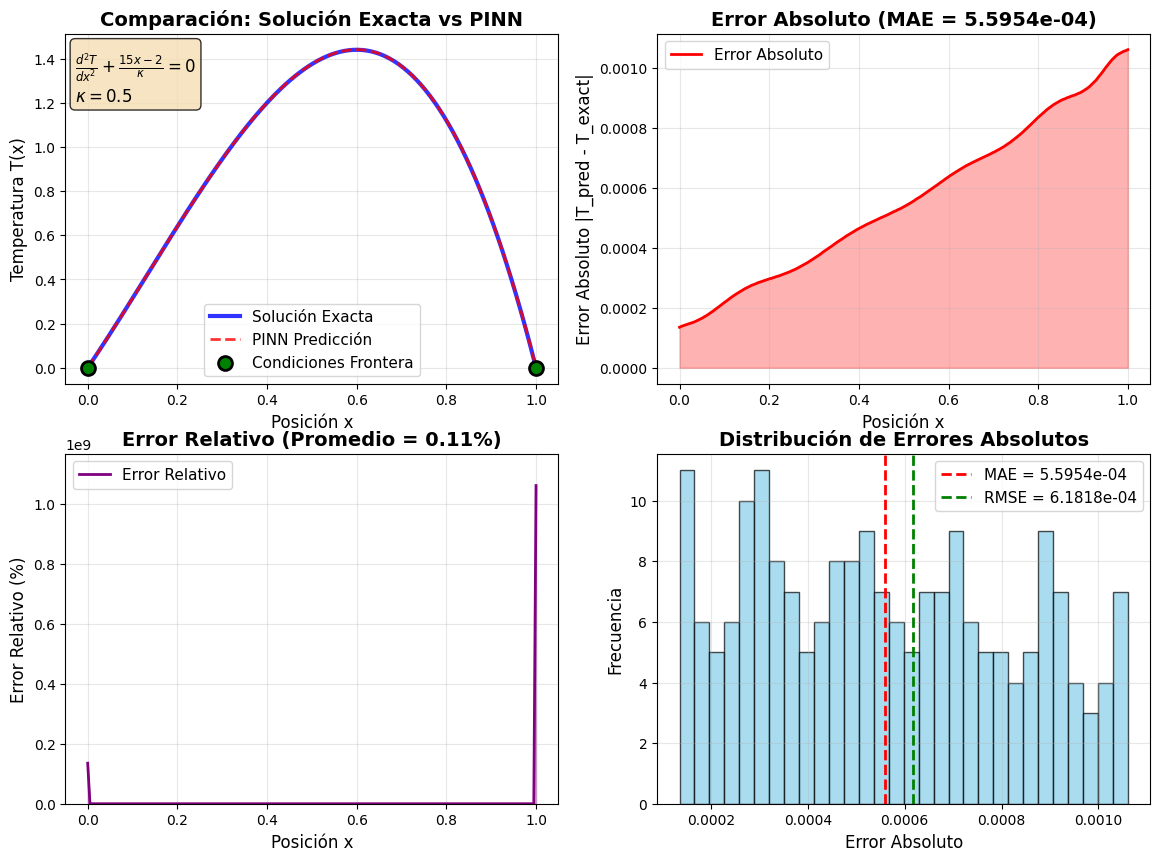

In [15]:
# ============================================================================
# 4. CREAR GRÁFICAS
# ============================================================================

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ==============================================
# Gráfica 1: Solución Exacta vs Predicha
# ==============================================
ax1 = axes[0, 0]
ax1.plot(x_test_np, T_exact_np, 'b-', linewidth=3, label='Solución Exacta', alpha=0.8)
ax1.plot(x_test_np, T_pred_np, 'r--', linewidth=2, label='PINN Predicción', alpha=0.8)
ax1.scatter([0, 1], [0, 0], color='green', s=100, zorder=5,
           label='Condiciones Frontera', edgecolor='black', linewidth=2)

ax1.set_xlabel('Posición x', fontsize=12)
ax1.set_ylabel('Temperatura T(x)', fontsize=12)
ax1.set_title('Comparación: Solución Exacta vs PINN', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xlim([-0.05, 1.05])

# Anotar la ecuación en la gráfica
equation_text = r'$\frac{d^2T}{dx^2} + \frac{15x-2}{\kappa} = 0$' + f'\n' + r'$\kappa = 0.5$'
ax1.text(0.02, 0.95, equation_text, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ==============================================
# Gráfica 2: Error Absoluto
# ==============================================
ax2 = axes[0, 1]
ax2.plot(x_test_np, absolute_error, 'r-', linewidth=2, label='Error Absoluto')
ax2.fill_between(x_test_np, 0, absolute_error, alpha=0.3, color='red')

ax2.set_xlabel('Posición x', fontsize=12)
ax2.set_ylabel('Error Absoluto |T_pred - T_exact|', fontsize=12)
ax2.set_title(f'Error Absoluto (MAE = {mae:.4e})', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_xlim([-0.05, 1.05])

# ==============================================
# Gráfica 3: Error Relativo
# ==============================================
ax3 = axes[1, 0]
ax3.plot(x_test_np, relative_error * 100, 'purple', linewidth=2, label='Error Relativo')
ax3.fill_between(x_test_np, 0, relative_error * 100, alpha=0.3, color='purple')

ax3.set_xlabel('Posición x', fontsize=12)
ax3.set_ylabel('Error Relativo (%)', fontsize=12)
ax3.set_title(f'Error Relativo (Promedio = {mean_relative_error*100:.2f}%)',
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)
ax3.set_xlim([-0.05, 1.05])
ax3.set_ylim([0, max(relative_error * 100) * 1.1])

# ==============================================
# Gráfica 4: Histograma de Errores
# ==============================================
ax4 = axes[1, 1]
n_bins = 30
ax4.hist(absolute_error, bins=n_bins, color='skyblue', edgecolor='black', alpha=0.7)
ax4.axvline(mae, color='red', linestyle='--', linewidth=2,
           label=f'MAE = {mae:.4e}')
ax4.axvline(rmse, color='green', linestyle='--', linewidth=2,
           label=f'RMSE = {rmse:.4e}')

ax4.set_xlabel('Error Absoluto', fontsize=12)
ax4.set_ylabel('Frecuencia', fontsize=12)
ax4.set_title('Distribución de Errores Absolutos', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)


In [16]:
# ==============================================
# Ajustar diseño y mostrar
# ==============================================
plt.suptitle('Validación PINN: Ecuación del Calor 1D',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [17]:
# ============================================================================
# 5. VALIDACIÓN ADICIONAL: VERIFICAR RESIDUAL DE LA PDE
# ============================================================================

print("\n" + "=" * 60)
print("VALIDACIÓN DEL RESIDUAL DE LA PDE")
print("=" * 60)

# Recalcular el residual usando el modelo entrenado
def calculate_residual(model, x_points):
    """Calcular residual d²T/dx² + (15x-2)/κ"""
    x_tensor = tf.convert_to_tensor(x_points.reshape(-1, 1), dtype=tf.float32)

    with tf.GradientTape() as tape2:
        tape2.watch(x_tensor)
        with tf.GradientTape() as tape1:
            tape1.watch(x_tensor)
            T = model(x_tensor)
        T_x = tape1.gradient(T, x_tensor)
    T_xx = tape2.gradient(T_x, x_tensor)

    residual = T_xx.numpy().flatten() + (15*x_points - 2)/kappa
    return residual

# Calcular residual en puntos de prueba
residuals = calculate_residual(model, x_test_np)
mean_residual = np.mean(np.abs(residuals))
max_residual = np.max(np.abs(residuals))

print(f"Residual medio absoluto: {mean_residual:.6e}")
print(f"Residual máximo absoluto: {max_residual:.6e}")
print(f"¿El residual es cercano a cero? {'SÍ' if mean_residual < 0.01 else 'NO'}")


VALIDACIÓN DEL RESIDUAL DE LA PDE
Residual medio absoluto: 8.335817e-03
Residual máximo absoluto: 8.064651e-02
¿El residual es cercano a cero? SÍ


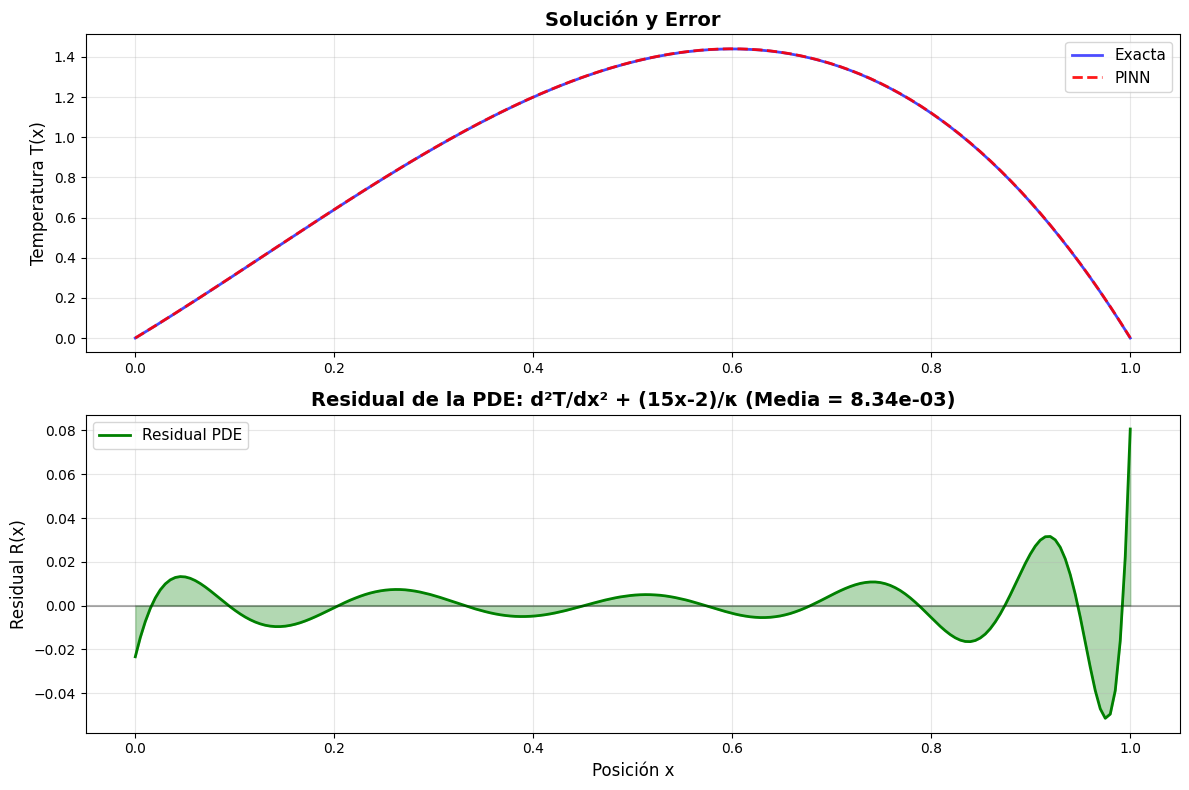

In [18]:
# ============================================================================
# 6. GRÁFICA ADICIONAL: SOLUCIÓN Y RESIDUAL
# ============================================================================

fig2, (ax5, ax6) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfica superior: Solución y residual
ax5.plot(x_test_np, T_exact_np, 'b-', linewidth=2, label='Exacta', alpha=0.7)
ax5.plot(x_test_np, T_pred_np, 'r--', linewidth=2, label='PINN', alpha=0.9)
ax5.fill_between(x_test_np, T_exact_np, T_pred_np, alpha=0.2, color='gray')
ax5.set_ylabel('Temperatura T(x)', fontsize=12)
ax5.set_title('Solución y Error', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=11)

# Gráfica inferior: Residual de la PDE
ax6.plot(x_test_np, residuals, 'g-', linewidth=2, label='Residual PDE')
ax6.fill_between(x_test_np, 0, residuals, alpha=0.3, color='green')
ax6.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax6.set_xlabel('Posición x', fontsize=12)
ax6.set_ylabel('Residual R(x)', fontsize=12)
ax6.set_title(f'Residual de la PDE: d²T/dx² + (15x-2)/κ (Media = {mean_residual:.2e})',
              fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.legend(fontsize=11)

plt.tight_layout()
plt.show()
